# This notebook is intended to generate color images by stacking multi-band images

### import packages

In [1]:
import glob
import sep
import numpy as np
from astropy.wcs import WCS
import astropy.io.fits as pyfits
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as interp

# Outline:
#### When Starting a project like this it is best to list the steps we need to program in order to achieve our programatic goal. - an Algorithm!

* The best place to start is with the goal: 

    * Stacking multi-band images and assigning the different color values, then plotting the result

* What do we have?  A list of fits images. Inside the headers of those images are the filter names they were taken in.

## Let's get our filter list!

In [2]:
files = glob.glob('*fits')
filters = []
for file in files:
    #get the filter from the header
    _filter = pyfits.getheader(file)['FILTER']
    filters.append(_filter)
filters = np.array(filters)
files = np.array(files)
print ('All the filters we have: ', np.unique(filters))

All the filters we have:  ['B' 'R' 'V']


## Now...

I want to see what files belong to each filter, lets create a dictionary...

## Exercise!

<font color=blue>
    What I want to create is a Dictionary called: <b>info</b><br>
    Where:
    <ul>
        <li>key=filter_name</li>
        <li>value=a list [] of file_names for that filter</li>
    </ul>
</font>

#### Hints
 * a dictionary is instantiated as: `info = {'B':[], 'R':[], 'V':[]}`
 * create a loop over the files (like above) and `info[filter].append()` those files to their correct filter dictionary element 

In [3]:
info = {'B':[], 'R':[], 'V':[]}
for file in files:
    _filter = pyfits.getheader(file)['FILTER']
    info[_filter].append(file)
info

{'B': ['M83_AP_6150365_B_000.fits', 'M83_AP_6150365_B_001.fits'],
 'R': ['M83_AP_6150365_R_002.fits'],
 'V': ['M83_AP_6150365_V_001.fits']}

# Cool!
Now let's do what we normally do and visualize where our data lives

## Exercise
<font color=blue>
    <ul>
        <li>Grab the B band entry's first image from our dictionary</li>
        <li>Plot the histogram of its data</li>
    </ul>
</font>
### Hints

* use the `pyfits.getdata(filename)` to get the image data
* plot it using `plt.hist(data.flatten(), bins=nbins, range=(lower, higher))`
    * you're going to have to figure out nbins, lower, higher on your own ; )


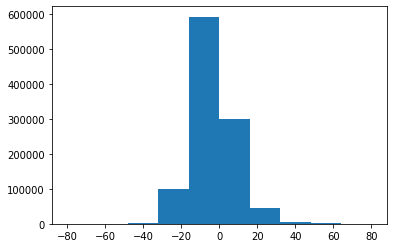

In [4]:
data = pyfits.getdata(info['B'][0])
image_hist = plt.hist(data.flatten(), bins=10, range=(-80, 80))

# Now...

Lets plot an example image

* <font color=blue>From the histogram above, what values would you use for `vmin` and `vmax`??</font>

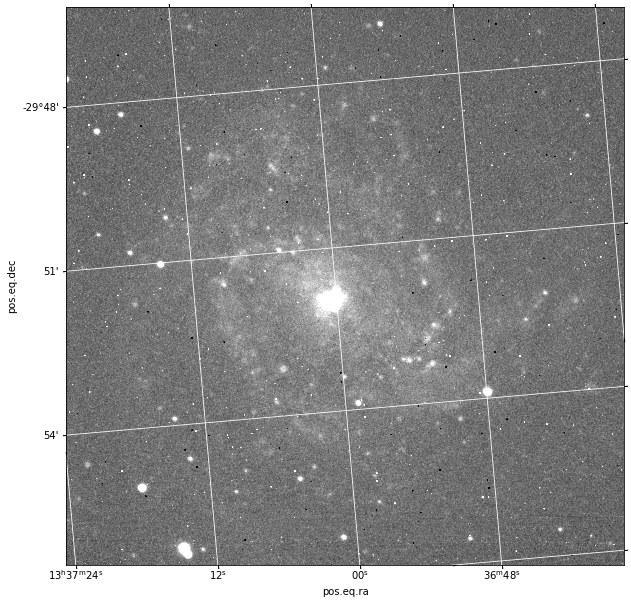

In [5]:
vmin, vmax =  -40, 40

fig= plt.figure(figsize=(10,12))

#grab the coordinate solution to plot the RA/DEC grid
header = pyfits.getheader(info['B'][0])
wcs = WCS(header)
ax = plt.subplot(projection=wcs)

#plot the image
data = pyfits.getdata(info['B'][0])
ax.imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.grid(color='white', ls='solid')

# Image Stacking

### How to:

* Loop over each filter
    * create a temporary dataset full of zeroes at the size we need
    * loop over each file in the respective filters file_list
        * get the image data and add it to our temporary dataset
    * average the coadded data by the number of files
    * save our averaged data to a dictionary with filters as the key

In [6]:
#Here is the dictionary we want to return
band_image = {}
#the size of our image: 1024x1024
image_size = np.shape(data)

#loop over our filter:files dictionary
for band in info.keys():
    print('Stacking all images in filter: {}'.format(band))
    #creating a temporary data array
    _data = np.zeros(image_size)
    
    #loop over our files list
    band_files = info[band]
    for file in band_files:
        #add up all of our data
        _data += pyfits.getdata(file)
    
    averaged_data = _data/float(len(band_files))
    band_image.update({band: averaged_data})

Stacking all images in filter: B
Stacking all images in filter: R
Stacking all images in filter: V


# Let's plot our stacked data

* How will we do this:
    * our bands need to be ordered from red-blue
    * we loop over these ordered bands
        * append the data to our simpleRGB list after applying a scale factor 
        * the scale factor will be from 0-1, closer to 1 the brighter the image will be in that color
        
    * `ax.imshow(simpleRGB)`

/Users/crisp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


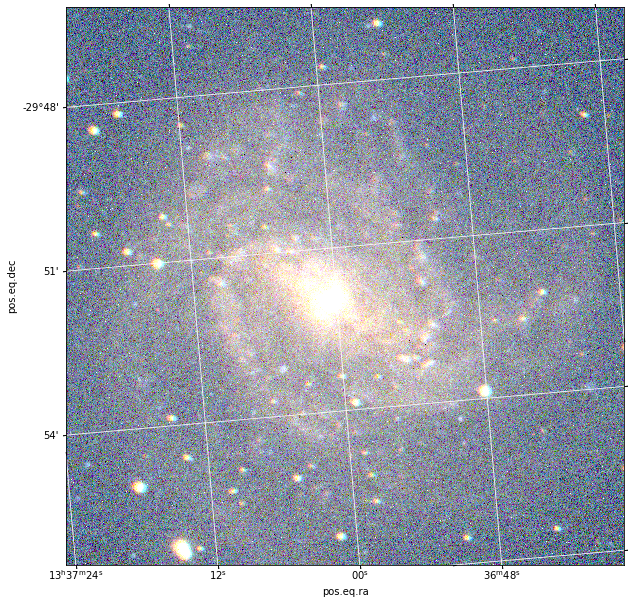

In [7]:

bands = ['R', 'V', 'B'] # This needs to be ordered as R/G/B
scale_factor = np.array([1, 0.9, 1.0])*1.
size = 1024
simpleRGB=np.zeros((size,size,3),dtype=float)


for i in range(len(bands)):
    data = band_image[bands[i]].copy()
    #data = shift_band_image[bands[i]].copy()
    min_value = np.quantile(data, [0.02, 1-0.02])[0]
    max_value = np.quantile(data, [0.02, 1-0.02])[1]
    data = (data - min_value)/(max_value-min_value)
    simpleRGB[:,:,i]=(data*scale_factor[i])**0.5

fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
ax.grid(color='white', ls='solid')
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest',vmin=-40, vmax=50)

# Hmmm....

It looks good, but not that great. The image stacking doesn't appear to be the greatest

We can do better... we will do better...

<font color=blue>But how... ?</font> any Ideas?
.

.

.

.

.

.

.

.

### Let's Try shifting the all of the images based off a reference image offset!

### How can we do this:

* set the first image in our list as a reference
* use `sep` to find the objects in the reference image
* before stacking and averaging our data. Loop over every object in the iterated image, and the reference objects
    * find the average offset by calculating the distance between the ref_obj and the iterated obj
    * use a `scipy.ndimage.interpolate.shift()` to shift our data based off the offset
* stack and average our offset image


In [8]:
#Here is a function that searches for a reference object
# once it finds it, it returns the shift in the x and y directions

def find_offset(ref_x, ref_y, _data):
    #Get the objects in our current image
    _data = _data.byteswap().newbyteorder()
    _data_bkg = sep.Background(_data)
    data_objs = sep.extract(_data, thresh=20.0, err=_data_bkg.globalrms, minarea=8)
    
    #loop over them and calculate their distances
    for i,j in enumerate(data_objs['x']):
        shift_x = ref_x - data_objs['x'][i]
        shift_y = ref_y - data_objs['y'][i]
        distance = np.sqrt((shift_x)**2+(shift_y)**2)
        
        # if the distance is less than this threshhold, its a match
        # return the offset x,y
        if distance < 10:
            return shift_x, shift_y
            break

In [9]:
shift_band_image = {}

simpleRGB=np.zeros((size,size,3),dtype=float)

image_size = np.shape(data)
#These commands get the reference image objects
ref_file = info[list(info.keys())[0]][0]
ref_img = pyfits.getdata(ref_file)
ref_img = ref_img.byteswap().newbyteorder() # magic command
ref_bkg = sep.Background(ref_img)
ref_objects = sep.extract(ref_img, thresh=20.0, err=ref_bkg.globalrms, minarea=10)

#loop over the bands: RGB
for band in info.keys():
    print('Stacking all images in filter: {}'.format(band))
    _shift_data = np.zeros(image_size)
    
    #loop over the files associated with each band
    for file in info[band]:
        
        #get the image data
        tmp_data = pyfits.getdata(file)
        
        #our lists to hold the offsets
        sx, sy = [], []
        
        #loop over each reference object
        for i,j in enumerate(ref_objects['x']):
            #find and append the offsets to our lists
            tmp_sx, tmp_sy = find_offset(ref_objects['x'][i], ref_objects['y'][i], tmp_data)
            sx.append(tmp_sx)
            sy.append(tmp_sy)

        #calculate the average offset
        shift_x, shift_y = np.mean(sx), np.mean(sy)

        print('Average offsets in x: {}, y: {}\n'.format(round(shift_x, 3), round(shift_y, 3)))
        
        #scipy method that shifts the image based off these offsets
        new_data = interp.shift(tmp_data, [shift_y, shift_x])
        #new coadded data from the shift
        _shift_data += new_data

    shift_band_image.update({band: _shift_data/float(len(info[band]))})

Stacking all images in filter: B
Average offsets in x: 0.0, y: 0.0

Average offsets in x: 0.0, y: 0.0

Stacking all images in filter: R
Average offsets in x: 6.918, y: -0.833

Stacking all images in filter: V
Average offsets in x: 2.734, y: -0.113



# Lets plot our aligned/stacked data 

/Users/crisp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


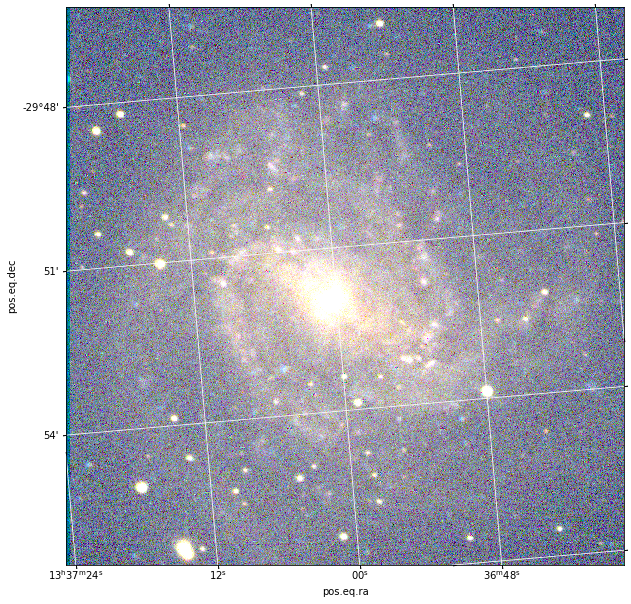

In [10]:
bands = ['R', 'V', 'B'] # This needs to be ordered as R/G/B
scale_factor = np.array([1, 0.9, 1.0])*1.
size = 1024
simpleRGB=np.zeros((size,size,3),dtype=float)


for i in range(len(bands)):
    data = shift_band_image[bands[i]].copy()
    min_value = np.quantile(data, [0.02, 1-0.02])[0]
    max_value = np.quantile(data, [0.02, 1-0.02])[1]
    data = (data - min_value)/(max_value-min_value)
    simpleRGB[:,:,i]=(data*scale_factor[i])**0.5

fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
ax.grid(color='white', ls='solid')
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest',vmin=-40, vmax=50)#interpolation='nearest'
#plt.plot(objects['x'],objects['y'],'xr')

# Perfect!

Show your friends and family, let them know you know how to make the Astronomy pictures the same way the hubble does!

Save all of your notebooks and save them for future projects. 

It's been a wonderful semester, and I hope you have a great summer : )